# Live Tweet Analysis: Amici di Maria De Filippi

Episode: 2021, December 19

**GOAL**: Detect the most tweeted contestants of the talent show **Amici di Maria De Filippi**, split between singers and dancers, during the broadcast of the show. The same analysis will be made between the teachers.

**NOTES**:
* The show airs at 2 P.M. CET. The analysis will start before that moment.

## Required libraries

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.streaming import StreamingContext
from time import time
import datetime as dt
import string
import seaborn as sns
import matplotlib.pyplot as plt

## Variables

In [ ]:
BATCH_DURATION = 5
PORT = 9999
hostname = "localhost"
checkpoint = "/home/daniel/checkpoint"
fig_sing = "output/Amici21_12_19_sing"
fig_dance = "output/Amici21_12_19_dance"
fig_teach = "output/Amici21_12_19_teach"

## Spark instance and Streaming Context

In [ ]:
sc = SparkContext()
ssc = StreamingContext(sc, BATCH_DURATION)
ssc.checkpoint(checkpoint)
lines = ssc.socketTextStream(hostname, PORT)

## Spark Session

In [ ]:
def get_spark_session(spark_context):
    if ("sqlContextSingletonInstance" not in globals()):
        globals()["sqlContextSingletonInstance"] = SparkSession \
                            .builder \
                            .config(conf=spark_context) \
                            .getOrCreate()
    return globals()["sqlContextSingletonInstance"]

## Data preprocessing

In [ ]:
def aggregate_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [ ]:
# Remove any hashtags and punctuation and make the word lowercase with the first letter uppercase
def clean_hashtag(word):
    return word.lower().capitalize().translate(str.maketrans('', '', string.punctuation))

In [ ]:
# Replace surnames or aliases with the names in the list
def change_name(name):
    if name in list(full_names.keys()):
        return full_names[name]
    else:
        return name

## Timestamp

In [ ]:
def format_timestamp(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
def print_timedelta(date_start):
    print("Start tweet analysis: " + format_timestamp(date_start))
    date_now = dt.datetime.now()
    print("Last update: " + format_timestamp(date_now))
    delta = date_now - date_start
    delta_seconds = delta.seconds
    delta_hours = delta_seconds/3600
    delta_minutes = (delta_seconds/60)%60
    delta_seconds = delta_seconds%60
    if delta.days!=0:
        print("Elapsed time: %d days, %d hours, %d minutes, %d seconds" 
                % (delta.days, delta_hours, delta_minutes, delta_seconds))
    else:
        print("Elapsed time: %d hours, %d minutes, %d seconds" 
                % (delta_hours, delta_minutes, delta_seconds))

## RDD processing

In [ ]:
def process_rdd(time, rdd):
    if (rdd.count()>0):
        spark = get_spark_session(rdd.context.getConf())
        row_rdd = rdd.map(lambda w: Row(Name=w[0], Count=w[1]))
        table_df = spark.createDataFrame(row_rdd)
        table_df = table_df.createOrReplaceTempView("TempView")

In [ ]:
def from_list_to_view(time, names_list, view_name):
    if (len(names_list)>0):
        names_rdd = sc.parallelize(names_list)
        spark = get_spark_session(names_rdd.context.getConf())
        row_rdd = names_rdd.map(lambda w: Row(Name=w))
        table_df = spark.createDataFrame(row_rdd)
        table_df = table_df.createOrReplaceTempView(view_name)

## Contestants and teachers

List of the singers (contestants) still inside the competition:
* Aisha Maryam
* Albe (Alberto La Malfa)
* Alex (Alessandro Rina)
* Crytical (Francesco Paone)
* Elena Manuele
* Luigi Strangis
* LDA (Luca D'Alessio)
* Nicol Castagna
* Rea (Maria Mircea)
* Sissi (Silvia Cesana)

In [ ]:
singers = ["Aisha","Albe","Alex","Crytical","Elena","Luigi","LDA","Nicol","Rea","Sissi"]
from_list_to_view(time, singers, "singers_df")

List of the dancers (contestants) still in the competition:
* Carola Puddu
* Christian Stefanelli
* Cosmary Fasanelli
* Cristiano La Bozzetta
* Dario Schirone
* Mattia Zenzola
* Serena Carella

In [ ]:
dancers = ["Carola","Christian","Cosmary","Cristiano","Dario","Mattia","Serena"]
from_list_to_view(time, dancers, "dancers_df")

List of the teachers:
* Rudy Zerbi
* Lorella Cuccarini
* Anna Pettinelli
* Alessandra Celentano
* Raimondo Todaro
* Veronica Peparini

In [ ]:
teachers = ["Pettinelli","Zerbi","Cuccarini","Celentano","Todaro","Peparini"]
from_list_to_view(time, teachers, "teachers_df")

Dictionary with surnames, nicknames, aliases.

In [ ]:
full_names = {"Anna":"Pettinelli","Annapettinelli":"Pettinelli",
             "Rudy":"Zerbi","Rudyzerbi":"Zerbi",
             "Lorella":"Cuccarini","Lorellacuccarini":"Cuccarini","Lcuccarini":"Cuccarini",
             "Alessandra":"Celentano","Alessandracelentano":"Celentano",
             "Cele":"Celentano","Alecelentano":"Celentano",
             "Raimondo":"Todaro","Raimondotodaro":"Todaro",
             "Veronica":"Peparini","Veronicapeparini":"Peparini","Verop7":"Peparini",
             "Maryam":"Aisha","Aishamaryam":"Aisha",
             "Alberto":"Albe","Malfa":"Albe",
             "Alessandro":"Alex","Rina":"Alex",
             "Francesco":"Crytical","Paone":"Crytical",
             "Manuele":"Elena","Elenamanuele":"Elena",
             "Strangis":"Luigi","Luigistrangis":"Luigi","Strangisluigi":"Luigi",
             "Luca":"LDA","Lda":"LDA",
             "Castagna":"Nicol","Nicolcastagna":"Nicol",
             "Mircea":"Rea",
             "Silvia":"Sissi","Cesana":"Sissi",
             "Puddu":"Carola","Carolapuddu":"Carola","Alorac22":"Carola",
             "Stefanelli":"Christian","Turbojr":"Christian",
             "Fasanelli":"Cosmary","Cosmaryfasanelli":"Cosmary",
             "Bozzetta":"Cristiano","Cristianolbz99":"Cristiano","Cristianolabozzetta":"Cristiano",
             "Schirone":"Dario","Darioschirone":"Dario",
             "Zenzola":"Mattia","Mattiazenzola":"Mattia",
             "Carella":"Serena","Serenacarella":"Serena"}

## Discretized Stream

In [ ]:
keywords = singers + dancers + teachers

In [ ]:
lines.flatMap(lambda text: text.split()) \
        .map(lambda word: change_name(clean_hashtag(word))) \
        .filter(lambda word: word in keywords) \
        .map(lambda word: (word, 1)) \
        .updateStateByKey(aggregate_count) \
        .foreachRDD(process_rdd)

## Start Streaming

Start the script *tweets_stream.py* from the terminal, write the topic you want to monitor (*amici21*), then start streaming.

In [ ]:
ssc.start()

print("Start tweeet analysis...")
start = dt.datetime.now()

Start tweeet analysis...


## Tweet counter

### Query

In [ ]:
query_tweet_singers = "SELECT * FROM TempView \
                       WHERE Name IN \
                           (SELECT Name FROM singers_df) \
                       ORDER BY count DESC"

In [ ]:
query_tweet_dancers = "SELECT * FROM TempView \
                       WHERE Name IN \
                           (SELECT Name FROM dancers_df) \
                       ORDER BY count DESC"

In [ ]:
query_tweet_teachers = "SELECT * FROM TempView \
                        WHERE Name IN \
                            (SELECT Name FROM teachers_df) \
                        ORDER BY count DESC"

### Tweet analysis

In [ ]:
def tweet_analysis(query, fig_name, figsize=(12,8), palette=None, title=None):
    df_top = get_spark_session(sc).sql(query)
    df_top.show()
    df_top_pd = df_top.toPandas()

    plt.figure(figsize=figsize)
    sns.barplot(x="Count", y="Name", data=df_top_pd, palette=palette).set(title=title)
    plt.grid()
    plt.savefig(fig_name)
    plt.show()

Start tweet analysis: 2021-12-19 13:34:20
Last update: 2021-12-19 16:51:10
Elapsed time: 3 hours, 16 minutes, 50 seconds
+--------+-----+
|    Name|Count|
+--------+-----+
|    Alex|10381|
|   Luigi| 3084|
|   Sissi| 1226|
|     LDA| 1047|
|     Rea| 1033|
|    Albe|  861|
|   Aisha|  741|
|Crytical|  325|
|   Elena|  307|
|   Nicol|  176|
+--------+-----+



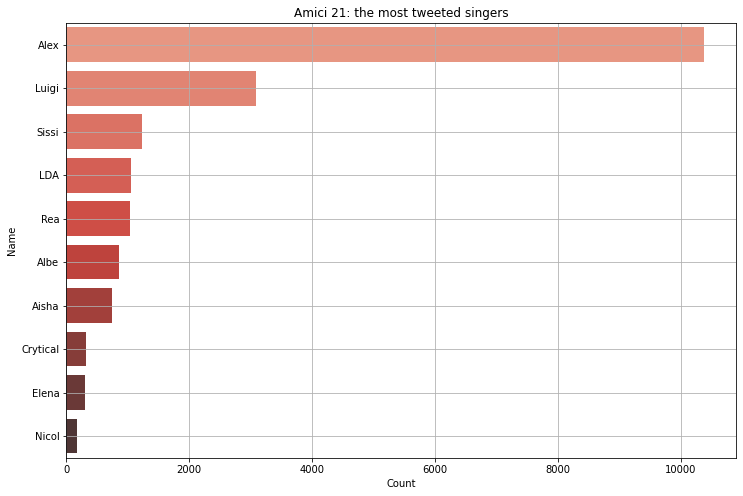

+---------+-----+
|     Name|Count|
+---------+-----+
|   Carola| 3284|
|  Cosmary| 1431|
|   Mattia| 1039|
|   Serena|  881|
|    Dario|  873|
|Christian|  870|
|Cristiano|  734|
+---------+-----+



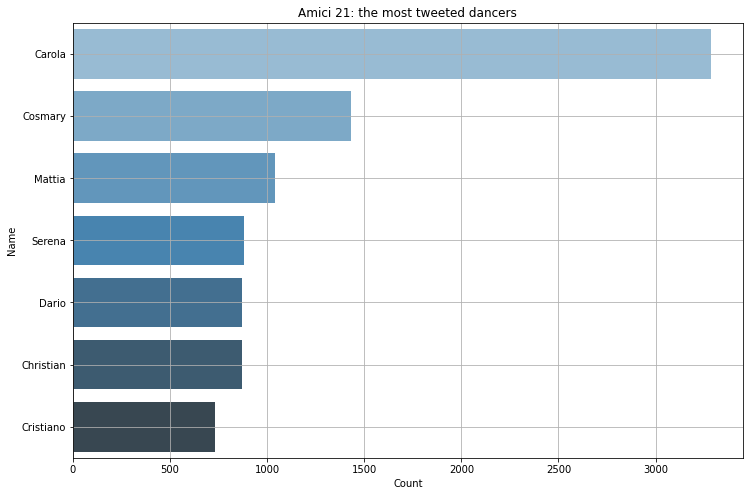

+----------+-----+
|      Name|Count|
+----------+-----+
| Celentano| 3927|
|    Todaro| 1378|
|Pettinelli|  494|
|  Peparini|  487|
|     Zerbi|  316|
| Cuccarini|  132|
+----------+-----+



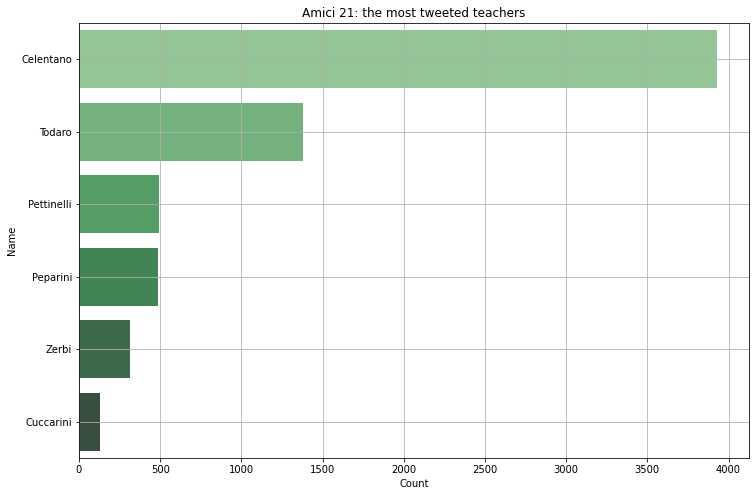

In [ ]:
print_timedelta(start)

# Tweet analysis of the singers
tweet_analysis(query_tweet_singers, fig_sing, palette="Reds_d",
               title="Amici 21: the most tweeted singers")

# Tweet analysis of the dancers
tweet_analysis(query_tweet_dancers, fig_dance, palette="Blues_d",
               title="Amici 21: the most tweeted dancers")

# Tweet analysis of the teachers
tweet_analysis(query_tweet_teachers, fig_teach, palette="Greens_d", 
               title="Amici 21: the most tweeted teachers")

In [ ]:
#ssc.stop()
#!sudo kill $(sudo lsof -t -i:9999)